In [1]:
import json
import os

import tqdm
import datetime
import pytz

import pandas

%matplotlib widget
import matplotlib
import matplotlib.pyplot

# General settings and experiment location

In [2]:
source_computer = 'beetle'
REAGGLOMERATE_FLAG = False
RECALCULATION_FLAG = True
root_path = '/Users/matthieu/.ssh/ssh_to_graz/metadata/' + source_computer + '/'
data_path = root_path + 'pickle_files/'
conf_path = root_path + 'config/'

pfiles = sorted([f for f in os.listdir(data_path) if f.endswith('.pickle')])
print(pfiles)

['metadata_waggles20230714.pickle', 'metadata_waggles20230715.pickle', 'metadata_waggles20230716.pickle', 'metadata_waggles20230717.pickle', 'metadata_waggles20230718.pickle', 'metadata_waggles20230719.pickle', 'metadata_waggles20230720.pickle', 'metadata_waggles20230721.pickle', 'metadata_waggles20230722.pickle', 'metadata_waggles20230723.pickle', 'metadata_waggles20230724.pickle', 'metadata_waggles20230725.pickle', 'metadata_waggles20230726.pickle', 'metadata_waggles20230727.pickle', 'metadata_waggles20230728.pickle', 'metadata_waggles20230729.pickle', 'metadata_waggles20230730.pickle', 'metadata_waggles20230731.pickle']


# Waggle runs gathering and cleaning

In [3]:
# Gather waggles
if REAGGLOMERATE_FLAG : 
    all_waggles_df = []
    for id_f, f in enumerate(pfiles) :
        if id_f == 0:
            all_waggles_df = pandas.read_pickle(data_path + f)
            continue

        meta_df = pandas.read_pickle(data_path + f)
        all_waggles_df = pandas.concat((all_waggles_df, meta_df), ignore_index=True)
    pandas.to_pickle(all_waggles_df, root_path+'all_waggles.pickle')
else :
    all_waggles_df = pandas.read_pickle(root_path+'all_waggles.pickle')

# Clean dataframe
all_waggles_df = all_waggles_df[~all_waggles_df.isnull().any(axis=1)]
all_waggles_df.head(5)

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_x,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance
0,18434927546356664479,205,-1.143186,4.589325,0.788175,2,2023-07-14 16:45:07.475806+00:00,2023-07-14 16:45:08.125847+00:00,1550.0,944.0,...,1550.0,960.0,2023-07-14,0.650041,-3.348960,-6.062942,-0.330431,-347.381006,-18.932303,True
1,17207792881295891939,205,-2.244534,4.589325,0.862588,2,2023-07-14 16:45:02.158845+00:00,2023-07-14 16:45:02.775513+00:00,1586.0,960.0,...,1606.0,976.0,2023-07-14,0.616668,-3.348695,-7.164026,-0.330166,-410.468442,-18.917145,True
2,10734887546593850369,206,2.796986,2.929605,0.573601,2,2023-07-14 16:45:23.210104+00:00,2023-07-14 16:45:23.676807+00:00,1454.0,992.0,...,1446.0,1000.0,2023-07-14,0.466703,-3.349742,-2.123553,-1.990934,-121.670631,-114.072113,True
3,10228066394540439103,206,-3.097191,2.924824,0.752396,2,2023-07-14 16:45:27.126987+00:00,2023-07-14 16:45:27.293644+00:00,1446.0,1136.0,...,1446.0,1136.0,2023-07-14,0.166657,-3.349937,-8.017924,-1.995910,-459.393219,-114.357214,True
4,10436701760110499376,205,-1.186604,4.775544,0.751323,2,2023-07-14 16:45:09.292561+00:00,2023-07-14 16:45:09.575921+00:00,1526.0,944.0,...,1510.0,960.0,2023-07-14,0.283360,-3.349050,-6.106450,-0.144302,-349.873829,-8.267896,True


# Comb config processing : experiments times

In [4]:
# load config file
with open(conf_path+'comb_config.json', "r") as f:
    exp_configuration = json.load(f)

exp_configs = [[]]*len(exp_configuration['experiment']['timeslots'])
for conf_id, conf in enumerate(exp_configuration['experiment']['timeslots']):
    exp_config = conf
    exp_config['dtts_start'] = datetime.datetime.fromisoformat(conf["from"])
    exp_config['dtts_stop'] = datetime.datetime.fromisoformat(conf["to"])
    exp_configs[conf_id] = exp_config

# exp_configs

In [5]:
# load output bridge data
wdd_log_file = conf_path+'wdd_bridge_output.txt'
bridge_lines = []
corrupted_lines = 0
with open(wdd_log_file, "r") as f:
    for line in f:
        try :
            data = json.loads(line)
        except :
            corrupted_lines += 1
        data["UTC_timestamp"] = pytz.UTC.localize(datetime.datetime.fromisoformat(data["log_timestamp"]))
        bridge_lines.append(data)
print("Output contained {} corrupted lines".format(corrupted_lines))
bridge_output = pandas.DataFrame.from_dict(bridge_lines)

Output contained 0 corrupted lines


# Dances clustering and visu (Day by day)

In [6]:
day_oi = pytz.utc.localize(datetime.datetime(2023, 7, 17))

daily_waggles = all_waggles_df[all_waggles_df.timestamp_begin > day_oi]
daily_waggles = daily_waggles[daily_waggles.timestamp_begin < day_oi+datetime.timedelta(1)]

daily_waggles

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_x,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance
33391,11259289948797564861,1,2.474653,2.054171,0.595191,2,2023-07-17 01:59:48.372926+00:00,2023-07-17 01:59:48.921504+00:00,510.0,1352.0,...,510.0,1352.0,2023-07-17,0.548578,0.852468,1.756325,1.335843,100.629993,76.538160,True
33392,13683297272885716500,1,1.633690,2.054171,0.718310,2,2023-07-17 01:59:49.388092+00:00,2023-07-17 01:59:50.889438+00:00,510.0,1352.0,...,510.0,1352.0,2023-07-17,1.501346,0.852406,0.915300,1.335781,52.442805,76.534638,True
33395,14536671084482940562,1865,-1.485406,5.239919,0.454770,2,2023-07-17 16:45:44.942192+00:00,2023-07-17 16:45:45.396203+00:00,1438.0,1024.0,...,1446.0,1032.0,2023-07-17,0.454011,-3.343540,-6.399743,0.325582,-366.678255,18.654497,True
33396,18114147233753668341,1865,1.557128,5.239919,0.679846,2,2023-07-17 16:45:44.414293+00:00,2023-07-17 16:45:44.630916+00:00,1458.0,1044.0,...,1458.0,1044.0,2023-07-17,0.216623,-3.343514,-3.357182,0.325609,-192.352367,18.656007,True
33397,13175791678524710877,1865,-2.250627,3.485226,0.543436,2,2023-07-17 16:45:50.246459+00:00,2023-07-17 16:45:50.798106+00:00,1590.0,1056.0,...,1582.0,1072.0,2023-07-17,0.551647,-3.343805,-7.165229,-1.429375,-410.537360,-81.897183,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47894,15888739015325376838,46,-2.958773,3.645319,0.938843,2,2023-07-17 05:59:21.329993+00:00,2023-07-17 05:59:23.313421+00:00,962.0,1116.0,...,910.0,1104.0,2023-07-17,1.983428,0.092811,-4.436758,2.167334,-254.207510,124.179093,True
47896,17157227178998577394,7,0.899085,1.269778,0.401221,2,2023-07-17 05:42:41.444573+00:00,2023-07-17 05:42:41.828626+00:00,1478.0,1024.0,...,1470.0,1040.0,2023-07-17,0.384053,0.143596,-0.528115,-0.157422,-30.258772,-9.019629,True
47897,17901195682451183287,7,1.877684,1.468512,0.808414,2,2023-07-17 05:42:34.860604+00:00,2023-07-17 05:42:35.194850+00:00,1642.0,1144.0,...,1646.0,1136.0,2023-07-17,0.334246,0.143928,0.450815,0.041644,25.829825,2.386013,True
47898,10870639589343684663,7,1.059340,1.468512,0.826374,2,2023-07-17 05:42:38.811798+00:00,2023-07-17 05:42:39.761901+00:00,1526.0,1040.0,...,1542.0,1024.0,2023-07-17,0.950103,0.143729,-0.367727,0.041444,-21.069219,2.374593,True


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class DBSCAN:
    def __init__(self, min_samples, tol_time, tol_x, tol_y, tol_angle):
        self.min_samples = min_samples
        self.tol_time = tol_time
        self.tol_x = tol_x
        self.tol_y = tol_y
        self.tol_angle = tol_angle

    def connection_function(self, pt0, pt1):
        if abs((pt1.timestamp_begin - pt0.timestamp_begin).total_seconds()) > self.tol_time:
            return 0
        if abs(pt1.wdd_x - pt0.wdd_x) > self.tol_x:
            return 0
        if abs(pt1.wdd_y - pt0.wdd_y) > self.tol_y:
            return 0
        if abs(pt1.world_angle_deg - pt0.world_angle_deg)%360 > self.tol_angle:
            return 0
        return 1
    
    def fit(self, X):
        self.X = X
        self.labels = [0] * len(self.X)
        self.visited = [False] * len(self.X)
        self.cluster_id = 0

        for i in range(len(self.X)):
            if not self.visited[i]:
                self.visited[i] = True
                neighbors = self.region_query(i)

                if len(neighbors) < self.min_samples:
                    self.labels[i] = -1
                else:
                    self.cluster_id += 1
                    self.expand_cluster(i, neighbors)

    def region_query(self, i):
        neighbors = []
        for j in range(len(self.X)):
            if self.connection_function(self.X.iloc[i], self.X.iloc[j]):
                neighbors.append(j)
        return neighbors

    def expand_cluster(self, i, neighbors):
        self.labels[i] = self.cluster_id
        j = 0
        while j < len(neighbors):
            neighbor_idx = neighbors[j]

            if not self.visited[neighbor_idx]:
                self.visited[neighbor_idx] = True
                new_neighbors = self.region_query(neighbor_idx)

                if len(new_neighbors) >= self.min_samples:
                    neighbors += new_neighbors

            if self.labels[neighbor_idx] == 0:
                self.labels[neighbor_idx] = self.cluster_id

            j += 1


In [8]:
label_conf   = 0.99  # percent
clustering_df = daily_waggles[daily_waggles.label_confidence>label_conf]
clustering_df = clustering_df[clustering_df.timestamp_begin>day_oi+datetime.timedelta(hours=14)]
clustering_df = clustering_df[clustering_df.timestamp_begin<day_oi+datetime.timedelta(hours=16)]

print(len(clustering_df))

599


In [9]:
angle_tol    = 30    # degrees
time_tol     = 5     # seconds
posx_tol     = 100   # pixels (100px ~ 25mm) trop restrictif?
posy_tol     = 100   # pixels
min_pts      = 3     # nb wr min to make a dance

# Apply DBSCAN (takes around 1min 40s for 600 datapoints (does not scale linearly : 2200pts --> more than 25 mins))
dbscan = DBSCAN(min_samples=min_pts, tol_time=time_tol, tol_x=posx_tol, tol_y=posy_tol, tol_angle=angle_tol)
dbscan.fit(clustering_df)
clustering_df['cluster'] = dbscan.labels
no_noise_df = clustering_df[clustering_df.cluster >= 0]

In [10]:
print("Total number of clusters (WD) : {}".format(clustering_df.cluster.unique().shape[0]-1))
# print("Size of the clusters (WR per WD) : min={}, max={}, average={}, median={}".format(clustering_df[clustering_df.cluster > 0].cluster.value_counts().min(), clustering_df[clustering_df.cluster > 0].cluster.value_counts().max(), clustering_df[clustering_df.cluster > 0].cluster.value_counts().mean(), clustering_df[clustering_df.cluster > 0].cluster.value_counts().median()))

Total number of clusters (WD) : 32


In [11]:
print(clustering_df[clustering_df.cluster > 0].cluster.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]


In [12]:
print(clustering_df[clustering_df.cluster > 0].cluster.value_counts())

10    7
18    7
14    5
1     4
30    4
6     4
24    4
23    4
15    3
31    3
29    3
26    3
25    3
20    3
32    3
9     3
11    3
8     3
7     3
13    2
19    2
12    2
21    2
4     2
5     2
28    1
3     1
16    1
27    1
2     1
22    1
17    1
Name: cluster, dtype: int64


In [13]:
print(clustering_df[clustering_df.cluster > 0].cluster.value_counts())

10    7
18    7
14    5
1     4
30    4
6     4
24    4
23    4
15    3
31    3
29    3
26    3
25    3
20    3
32    3
9     3
11    3
8     3
7     3
13    2
19    2
12    2
21    2
4     2
5     2
28    1
3     1
16    1
27    1
2     1
22    1
17    1
Name: cluster, dtype: int64


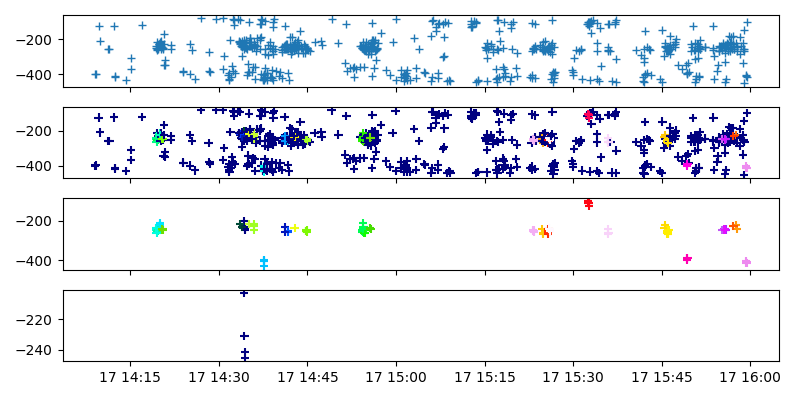

In [14]:
# Plot
fig, ax = matplotlib.pyplot.subplots(4, 1, figsize=(8, 4), sharex=True)
ax[0].plot(clustering_df.timestamp_begin, clustering_df.world_angle_deg, '+')
ax[1].scatter(clustering_df.timestamp_begin, clustering_df.world_angle_deg, c=clustering_df['cluster'], cmap='gist_ncar', marker='+')
ax[2].scatter(no_noise_df.timestamp_begin, no_noise_df.world_angle_deg, c=no_noise_df['cluster'], cmap='gist_ncar', marker='+')
cluster_oi = clustering_df[clustering_df.cluster == 1]
ax[3].scatter(cluster_oi.timestamp_begin, cluster_oi.world_angle_deg, c=cluster_oi['cluster'], cmap='gist_ncar', marker='+')
fig.tight_layout()

In [15]:
[print(x) for x in sorted(list(cluster_oi.timestamp_begin.values))]

2023-07-17T14:34:17.371859000
2023-07-17T14:34:19.231037000
2023-07-17T14:34:23.156928000
2023-07-17T14:34:25.756926000


[None, None, None, None]

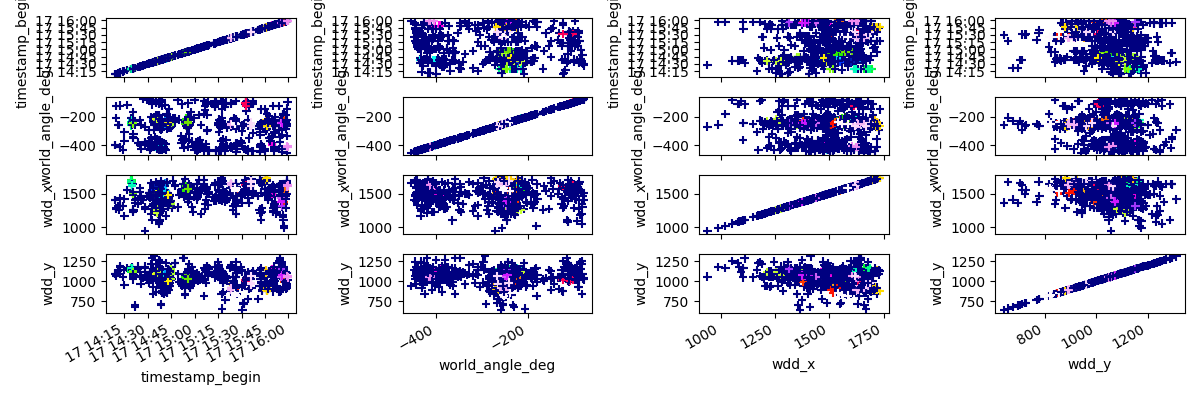

In [16]:
# Plot
features = ['timestamp_begin', 'world_angle_deg', 'wdd_x', 'wdd_y']
fig, ax = matplotlib.pyplot.subplots(len(features), len(features), figsize=(12, 4))
for i, feat1 in enumerate(features):
    for j, feat2 in enumerate(features):
        ax[i,j].scatter(clustering_df[feat2], clustering_df[feat1], c=clustering_df['cluster'], cmap='gist_ncar', marker='+')
        ax[i,j].set_ylabel(feat1)
        ax[i,j].set_xlabel(feat2)

# for i, feat1 in enumerate(features):
#     ax[i,0].set_ylabel(feat1)
#     ax[len(features)-1,i].set_xlabel(feat1)
matplotlib.pyplot.gcf().autofmt_xdate()
fig.tight_layout()

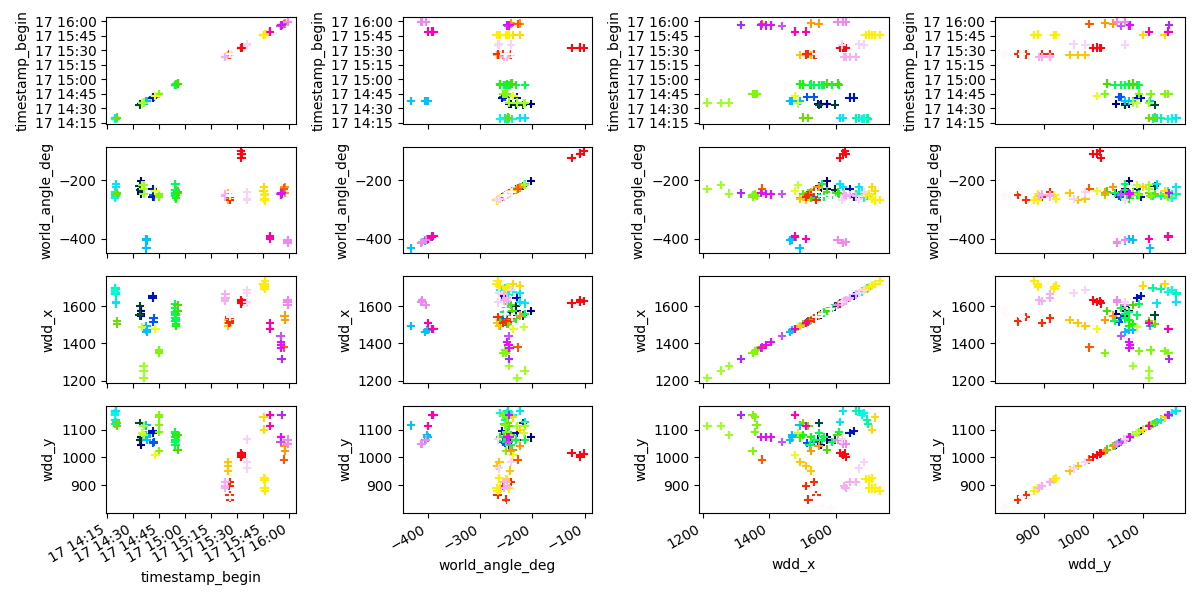

In [17]:
# Plot
features = ['timestamp_begin', 'world_angle_deg', 'wdd_x', 'wdd_y']
fig, ax = matplotlib.pyplot.subplots(len(features), len(features), figsize=(12, 6))
for i, feat1 in enumerate(features):
    for j, feat2 in enumerate(features):
        ax[i,j].scatter(no_noise_df[feat2], no_noise_df[feat1], c=no_noise_df['cluster'], cmap='gist_ncar', marker='+')
        ax[i,j].set_ylabel(feat1)
        ax[i,j].set_xlabel(feat2)

# for i, feat1 in enumerate(features):
#     ax[i,0].set_ylabel(feat1)
#     ax[len(features)-1,i].set_xlabel(feat1)
matplotlib.pyplot.gcf().autofmt_xdate()
fig.tight_layout()

In [18]:
no_noise_df.head(16)

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance,cluster
34406,14019350777343056987,1515,0.457161,0.346730,1.155401,2,2023-07-17 14:34:19.231037+00:00,2023-07-17 14:34:21.539453+00:00,1574.000000,1064.000000,...,1096.000000,2023-07-17,2.308416,-2.915804,-4.029440,-4.139870,-230.869907,-237.197105,True,1
34410,17749575903396792660,1515,0.945345,5.849869,0.945667,2,2023-07-17 14:34:17.371859+00:00,2023-07-17 14:34:18.873885+00:00,1574.000000,1072.000000,...,1048.000000,2023-07-17,1.502026,-2.915688,-3.541139,1.363385,-202.892307,78.116193,True,1
34416,11229808052670593350,1515,0.274202,0.331315,0.587476,2,2023-07-17 14:34:23.156928+00:00,2023-07-17 14:34:24.523415+00:00,1546.000000,1064.000000,...,1060.000000,2023-07-17,1.366487,-2.916051,-4.212645,-4.155532,-241.366759,-238.094445,True,1
34426,16843656881005123561,1515,0.203919,0.309001,1.056653,2,2023-07-17 14:34:25.756926+00:00,2023-07-17 14:34:27.089855+00:00,1555.345622,1045.345622,...,988.963545,2023-07-17,1.332929,-2.916214,-4.283091,-4.178009,-245.403037,-239.382278,True,1
34647,11021790547576384732,1514,0.441729,5.337992,0.924771,2,2023-07-17 14:33:55.337691+00:00,2023-07-17 14:33:56.805085+00:00,1598.000000,1064.000000,...,1064.000000,2023-07-17,1.467394,-2.914304,-4.043372,0.852891,-231.668123,48.867079,True,2
34649,11922127352584909002,1513,0.669261,0.615141,0.823629,2,2023-07-17 14:33:35.886317+00:00,2023-07-17 14:33:37.604593+00:00,1550.000000,1124.000000,...,1120.000000,2023-07-17,1.718276,-2.913082,-3.814617,-3.868737,-218.561483,-221.662303,True,3
34674,15133497904060748913,1558,0.490875,0.304587,0.910412,2,2023-07-17 14:41:08.862216+00:00,2023-07-17 14:41:09.962208+00:00,1642.000000,1088.000000,...,1080.000000,2023-07-17,1.099992,-2.941213,-4.021134,-4.207423,-230.394025,-241.067569,True,4
34679,13509842590855031221,1559,0.117251,0.476014,0.910592,2,2023-07-17 14:41:40.180133+00:00,2023-07-17 14:41:41.246564+00:00,1514.000000,1052.000000,...,1040.000000,2023-07-17,1.066431,-2.943133,-4.396678,-4.037916,-251.911113,-231.355517,True,5
34683,16128267091179690227,1559,0.037683,0.423754,1.117443,2,2023-07-17 14:41:42.412280+00:00,2023-07-17 14:41:43.980331+00:00,1534.000000,1056.000000,...,1048.000000,2023-07-17,1.568051,-2.943269,-4.476382,-4.090311,-256.477818,-234.357580,True,5
34684,18103841321924729558,1558,0.015120,0.231649,1.081229,2,2023-07-17 14:41:11.327556+00:00,2023-07-17 14:41:12.295597+00:00,1654.000000,1096.000000,...,1120.000000,2023-07-17,0.968041,-2.941364,-4.497041,-4.280512,-257.661469,-245.255283,True,4


In [19]:
dbscan.region_query(8)

[2, 8]

In [20]:
p0_dt = pytz.utc.localize(datetime.datetime(2023,7,17,14,25,0))
p1_dt = pytz.utc.localize(datetime.datetime(2023,7,17,14,35,0))
(p0_dt-p1_dt).total_seconds()

-600.0